##### Copyright 2025 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Getting started with the Gemini API OpenAI compatibility

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started_OpenAI_Compatibility.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

This example illustrates how to interact with the [Gemini API](https://ai.google.dev/gemini-api/docs) using the [OpenAI Python library](https://github.com/openai/openai-python).

This notebook will walk you through:

* Perform basic text generation using Gemini models via the OpenAI library
* Experiment with multimodal interactions, sending images on your prompts
* Extract information from text using structured outputs (ie. specific fields or JSON output)
* Use Gemini API tools, like function calling
* Generate embeddings using Gemini API models

More details about this OpenAI compatibility on the [documentation](https://ai.google.dev/gemini-api/docs/openai).

## Setup

### Install the required modules

While running this notebook, you will need to install the following requirements:
- The [OpenAI python library](https://pypi.org/project/openai/)
- The pdf2image and pdfminer.six (and poppler-utils as its requirement) to manipulate PDF files

In [2]:
%pip install -U -q openai pillow pdf2image pdfminer.six
!apt -qq -y install poppler-utils # required by pdfminer

Note: you may need to restart the kernel to use updated packages.
Error: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
Error: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


## Get your Gemini API key

You will need your Gemini API key to perform the activities part of this notebook. You can generate a new one at the [Get API key](https://aistudio.google.com/app/apikey) AI Studio page.

In [3]:
from openai import OpenAI


try:
  # if you are running the notebook on Google Colab
  # and if you have saved your API key in the
  # Colab secrets
  from google.colab import userdata

  GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
except:
  # enter manually your API key here if you are not using Google Colab
  GOOGLE_API_KEY="--enter-your-API-key-here--"

# OpenAI client
client = OpenAI(
    api_key=GOOGLE_API_KEY,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

## Define the Gemini model to be used

You can start by listing the available models using the OpenAI library.

In [5]:
models = client.models.list()
for model in models:
  if 'gemini-2.' in model.id:
    print(model.id)

models/gemini-2.5-pro-exp-03-25
models/gemini-2.5-pro-preview-03-25
models/gemini-2.5-flash-preview-04-17
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-2.0-flash-thinking-exp-01-21
models/gemini-2.0-flash-thinking-exp
models/gemini-2.0-flash-thinking-exp-1219
models/gemini-2.0-flash-live-001


## Define the Gemini model to be used

In this example, you will use the `gemini-2.0-flash` model. For more details about the available models, check the [Gemini models](https://ai.google.dev/gemini-api/docs/models/gemini) page from the Gemini API documentation.

In [6]:
MODEL="gemini-2.5-flash-preview-04-17"

## Initial interaction - generate text

For your first request, use the OpenAI SDK to perform text generation with a text prompt.

In [7]:
from IPython.display import Markdown

prompt = "What is generative AI?" # @param

response = client.chat.completions.create(
  model=MODEL,
  messages=[
    {"role": "system", "content": "You are a helpful assistant."},
    {
      "role": "user",
      "content": prompt
    }
  ]
)

Markdown(response.choices[0].message.content)

**Generative AI** refers to a type of artificial intelligence that can **create new content**, rather than just analyzing or classifying existing data.

Think of traditional AI often focusing on tasks like:
*   Identifying objects in an image (classification)
*   Predicting future trends based on past data (prediction)
*   Translating text (analysis and transformation)

Generative AI goes a step further. It learns the patterns, structures, and styles present in large datasets (like millions of images, pieces of text, or audio samples) and then uses that learning to produce entirely **new, original outputs** that resemble the training data but are not direct copies.

**In essence, it generates:**

*   **New text:** Writing essays, poems, code, emails, scripts, summaries.
*   **New images:** Creating artwork, realistic photos, designs, illustrations from descriptions.
*   **New audio:** Composing music, generating realistic speech, creating sound effects.
*   **New video:** Generating short clips, animations, or synthetic footage.
*   **New code:** Writing software code snippets or even entire programs.

**How it broadly works:**

It's typically powered by complex machine learning models (like Generative Adversarial Networks - GANs, Transformers, or Diffusion Models) trained on massive amounts of data. During training, the model learns the underlying distribution and relationships within the data, allowing it to then sample from that distribution to create novel examples.

**Examples you might have heard of:**

*   **Large Language Models (LLMs):** Like GPT (which powers ChatGPT), Bard, Llama - generating human-like text.
*   **Text-to-Image Models:** Like Midjourney, DALL-E, Stable Diffusion - creating images from text prompts.
*   **Music Generators:** Creating original musical pieces.
*   **Code Assistants:** Generating code snippets or explaining code (like GitHub Copilot).

Generative AI is a rapidly evolving field with applications spanning creative arts, writing, design, software development, education, and much more.

### Generating code

You can work with the Gemini API to generate code for you.

In [8]:
prompt = """
Write a C program that takes two IP addresses, representing the start and end of a range
(e.g., 192.168.1.1 and 192.168.1.254), as input arguments. The program should convert this
IP address range into the minimal set of CIDR notations that completely cover the given
range. The output should be a comma-separated list of CIDR blocks.
"""

response = client.chat.completions.create(
    model=MODEL,
    messages=[
        {
            "role": "user",
            "content": prompt
        }
    ]
)

Markdown(response.choices[0].message.content)

Okay, here is a C program that takes two IPv4 addresses as command-line arguments, representing the start and end of a range, and outputs the minimal set of CIDR blocks covering that range.

This program utilizes the `inet_pton` and `inet_ntop` functions from `<arpa/inet.h>` for IP address conversion and a greedy algorithm to find the minimal set of CIDR blocks.

```c
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <arpa/inet.h> // For inet_pton, inet_ntop
#include <sys/socket.h> // For AF_INET
#include <stdint.h>    // For uint32_t
#include <errno.h>     // For errno

// Function to convert a dotted-decimal IP string to a uint32_t
// Returns 0 on success, -1 on failure.
int ip_string_to_uint32(const char *ip_str, uint32_t *ip_val) {
    struct in_addr sa;
    if (inet_pton(AF_INET, ip_str, &sa) != 1) {
        return -1; // Invalid IP address format
    }
    *ip_val = ntohl(sa.s_addr); // Convert to host byte order for arithmetic
    return 0;
}

// Function to convert a uint32_t IP to a dotted-decimal string
// Returns a pointer to a static buffer containing the string (not thread-safe)
const char *uint32_to_ip_string(uint32_t ip_val) {
    struct in_addr sa;
    sa.s_addr = htonl(ip_val); // Convert back to network byte order
    static char ip_str[INET_ADDRSTRLEN]; // Static buffer
    if (inet_ntop(AF_INET, &sa, ip_str, INET_ADDRSTRLEN) == NULL) {
        return NULL; // Should not happen with a valid uint32_t
    }
    return ip_str;
}

int main(int argc, char *argv[]) {
    if (argc != 3) {
        fprintf(stderr, "Usage: %s <start_ip> <end_ip>\n", argv[0]);
        return EXIT_FAILURE;
    }

    uint32_t start_ip_val, end_ip_val;

    // Convert input strings to uint32_t
    if (ip_string_to_uint32(argv[1], &start_ip_val) == -1) {
        fprintf(stderr, "Error: Invalid start IP address '%s'\n", argv[1]);
        return EXIT_FAILURE;
    }
    if (ip_string_to_uint32(argv[2], &end_ip_val) == -1) {
        fprintf(stderr, "Error: Invalid end IP address '%s'\n", argv[2]);
        return EXIT_FAILURE;
    }

    // Ensure start_ip is less than or equal to end_ip
    if (start_ip_val > end_ip_val) {
        fprintf(stderr, "Warning: Start IP is greater than end IP. Swapping them.\n");
        uint32_t temp = start_ip_val;
        start_ip_val = end_ip_val;
        end_ip_val = temp;
    }

    uint32_t current_ip = start_ip_val;
    char *output_buffer = NULL;
    size_t buffer_size = 0;
    size_t current_len = 0;
    char cidr_str[INET_ADDRSTRLEN + 4]; // Max "255.255.255.255/32" + null

    while (current_ip <= end_ip_val) {
        int prefix_length = 32;
        uint64_t current_block_size = 1; // Use uint64_t to avoid overflow in size calculation

        // Find the largest possible prefix length (smallest block size exponent 32-n)
        // such that the block starts at current_ip and does not exceed end_ip.
        // Iterate from largest possible blocks (prefix /0) to smallest (/32).
        // A /n block starts at an address aligned to 2^(32-n) and has size 2^(32-n).
        for (int n = 0; n <= 32; ++n) {
             uint64_t size = 1ULL << (32 - n); // Size of a /n block

             // Check if current_ip is aligned for a /n block
             // (current_ip % size == 0)
             // And if the block fits within the remaining range
             // (current_ip + size - 1 <= end_ip)
             // The second check can be written as:
             // (uint64_t)current_ip + size - 1 <= end_ip
             // Or to avoid potential overflow with current_ip + size:
             // (uint64_t)end_ip - current_ip + 1 >= size
             // Use the difference check as it's safer. (end_ip - current_ip + 1) is the remaining range length.
            if ((current_ip % size) == 0 && ((uint64_t)end_ip - current_ip + 1) >= size) {
                // This block is possible. Keep track of the largest one found so far (smallest n).
                prefix_length = n;
                current_block_size = size;
                // Continue loop to find an even larger block (smaller n)
            } else {
                 // If this block size (and larger) is not possible, the previous one was the largest.
                 // Since we iterate n from 0 upwards (larger blocks first),
                 // the first time the condition is false, the previous n was the largest valid prefix.
                 // So, the largest valid prefix for this iteration is (n-1).
                 prefix_length = n - 1;
                 current_block_size = 1ULL << (32 - prefix_length);
                 break; // Found the largest possible block, exit the inner loop
            }
        }
        // Edge case: if loop finishes without break (only /0 fit), prefix_length would be 32+1=33.
        // This shouldn't happen if end_ip >= start_ip and they are uint32_t.
        // The smallest possible block is /32 (size 1), which always fits if current_ip <= end_ip.
        // Let's adjust the loop logic to iterate from 32 down to 0 to find the largest prefix (smallest n).
        // This is more intuitive for finding the "largest block".

        prefix_length = 32; // Start assuming the smallest block is the largest possible
        current_block_size = 1;

        for (int n = 32; n >= 0; --n) {
            uint64_t size = 1ULL << (32 - n); // Size of a /n block

            // Check if current_ip is aligned for a /n block
            // And if the block fits within the remaining range
           if ((current_ip % size) == 0 && ((uint64_t)end_ip - current_ip + 1) >= size) {
                // This block fits and is aligned. This is the largest such block.
                // Store this prefix and size and break, as iterating further down (smaller n)
                // would give larger blocks that we already know don't fit (or aren't aligned)
                // or the current block is the largest possible that is aligned and fits.
                prefix_length = n;
                current_block_size = size;
                break;
            }
        }
        // At this point, prefix_length and current_block_size represent the largest block
        // starting at current_ip that is entirely within [current_ip, end_ip].

        // Format the CIDR string
        const char *ip_str = uint32_to_ip_string(current_ip);
        if (ip_str == NULL) {
             fprintf(stderr, "Error converting IP to string for %u\n", current_ip);
             // Attempt to free buffer before exiting
             free(output_buffer);
             return EXIT_FAILURE;
        }
        int snprintf_res = snprintf(cidr_str, sizeof(cidr_str), "%s/%d", ip_str, prefix_length);
        if (snprintf_res < 0 || snprintf_res >= sizeof(cidr_str)) {
             fprintf(stderr, "Error formatting CIDR string.\n");
             // Attempt to free buffer before exiting
             free(output_buffer);
             return EXIT_FAILURE;
        }

        // Append to the output buffer
        size_t required_len = current_len + strlen(cidr_str) + (current_len > 0 ? 2 : 0) + 1; // +2 for ", ", +1 for null terminator
        if (required_len > buffer_size) {
            size_t new_size = buffer_size == 0 ? 128 : buffer_size * 2; // Start with 128, double thereafter
            while (new_size < required_len) {
                 new_size *= 2;
            }
            char *temp = realloc(output_buffer, new_size);
            if (temp == NULL) {
                 fprintf(stderr, "Error reallocating memory for output buffer\n");
                 free(output_buffer); // Free potentially existing buffer
                 return EXIT_FAILURE;
            }
            output_buffer = temp;
            buffer_size = new_size;
        }

        if (current_len > 0) {
            strcat(output_buffer, ", ");
            current_len += 2;
        }
        strcat(output_buffer, cidr_str);
        current_len += strlen(cidr_str);

        // Move to the next IP address to cover
        // Use uint64_t for this addition to safely check for exceeding UINT32_MAX
        uint64_t next_ip_val = (uint64_t)current_ip + current_block_size;

        // Check if we've finished or if adding the block size wraps around (shouldn't happen in valid ranges)
        if (next_ip_val > UINT32_MAX || next_ip_val <= current_ip) {
             // This indicates we covered up to or past end_ip, or an unexpected wrap/error
             current_ip = end_ip_val + 1; // Force loop termination
        } else {
             current_ip = (uint32_t)next_ip_val;
        }
    }

    if (output_buffer) {
        printf("%s\n", output_buffer);
        free(output_buffer);
    } else {
        // This case should only be reached if start_ip_val > end_ip_val initially and they were swapped,
        // resulting in an empty range after swap (start == end + 1), or if both inputs were invalid.
        // But the swap handles start > end. If start == end, it prints /32.
        // So, this else might indicate an error, or maybe just an empty output if the loop condition
        // was initially false (e.g., start_ip_val > end_ip_val and swap didn't happen due to error handling, or just logic bug).
        // With the current loop (current_ip <= end_ip_val), if start <= end, the loop runs at least once.
        // So, output_buffer should not be NULL here unless an allocation failed earlier.
         fprintf(stderr, "An unexpected error occurred or the range was empty after potential swap.\n");
         return EXIT_FAILURE;
    }


    return EXIT_SUCCESS;
}
```

**Explanation:**

1.  **Includes:** Necessary headers for input/output (`stdio.h`), memory allocation (`stdlib.h`), string manipulation (`string.h`), network functions (`arpa/inet.h`, `sys/socket.h`), integer types (`stdint.h`), and error handling (`errno.h`).
2.  **`ip_string_to_uint32`:** Converts a dotted-decimal string (e.g., "192.168.1.1") into a 32-bit unsigned integer. It uses `inet_pton` for robust parsing and validation, then `ntohl` to convert from network byte order to host byte order for standard integer arithmetic.
3.  **`uint32_to_ip_string`:** Converts a 32-bit unsigned integer back into a dotted-decimal string using `htonl` (host to network byte order) and `inet_ntop`. It uses a `static` buffer, making it non-thread-safe but simple for this program's scope.
4.  **`main` function:**
    *   Checks for the correct number of command-line arguments.
    *   Converts the input start and end IP strings to `uint32_t` values using `ip_string_to_uint32`. Includes error handling for invalid IP formats.
    *   Ensures `start_ip_val` is not greater than `end_ip_val` by swapping them if necessary.
    *   Initializes `current_ip` to `start_ip_val`. This variable tracks the beginning of the portion of the range that still needs to be covered by CIDR blocks.
    *   Initializes a dynamic `output_buffer` using `realloc` to store the resulting comma-separated CIDR strings.
    *   **Main Loop (`while (current_ip <= end_ip_val)`):** Continues as long as there are IP addresses left to cover in the range `[current_ip, end_ip_val]`.
        *   **Finding the Largest CIDR Block:** Inside the loop, it iterates from the largest possible prefix length (n=32, smallest block /32) down to the smallest (n=0, largest block /0).
            *   For each prefix length `n`, it calculates the `size` of the corresponding block (`2^(32-n)`). Using `1ULL` ensures the left shift uses `unsigned long long` to prevent overflow for larger block sizes before casting to `uint64_t`.
            *   It checks two conditions:
                1.  **Alignment:** `(current_ip % size) == 0` ensures that `current_ip` is the valid network address for a block of size `size`.
                2.  **Range Coverage:** `((uint64_t)end_ip_val - current_ip + 1) >= size` checks if the remaining addresses in the target range (`[current_ip, end_ip_val]`) are sufficient to contain a block of size `size` starting at `current_ip`. Using `uint64_t` for the difference prevents potential overflow issues if `end_ip_val` and `current_ip` are large and close to `UINT32_MAX`.
            *   The *first* prefix length `n` (iterating downwards from 32) that satisfies both conditions is the largest possible aligned block starting at `current_ip` that fits within the required end `end_ip_val`. The loop breaks once this is found.
        *   **Formatting and Appending Output:**
            *   Converts the `current_ip` (which is the network address of the found block) back to a dotted-decimal string.
            *   Formats the CIDR string (`ip_str/prefix_length`).
            *   Appends the formatted CIDR string to the `output_buffer`. It manages the buffer dynamically using `realloc` and adds a ", " separator before each block after the first.
        *   **Updating `current_ip`:** `current_ip` is advanced to the IP address immediately following the block just covered (`current_ip + current_block_size`). Using `uint64_t` for the addition helps detect if this step would theoretically wrap around `UINT32_MAX` (though for valid IPv4 ranges this shouldn't happen). If it doesn't wrap, the value is cast back to `uint32_t`. If it wraps or exceeds `UINT32_MAX`, the loop is forced to terminate.
    *   **Printing and Cleanup:** After the loop finishes, the contents of `output_buffer` are printed, and the memory is freed.

**How to Compile and Run:**

1.  Save the code as `ip2cidr.c`.
2.  Compile using a C compiler (like GCC):
    ```bash
    gcc ip2cidr.c -o ip2cidr -Wall -Wextra -pedantic
    ```
3.  Run the executable with the two IP addresses as arguments:
    ```bash
    ./ip2cidr 192.168.1.1 192.168.1.254
    ```

**Example Output for 192.168.1.1 to 192.168.1.254:**

```
192.168.1.1/32, 192.168.1.2/31, 192.168.1.4/30, 192.168.1.8/29, 192.168.1.16/28, 192.168.1.32/27, 192.168.1.64/26, 192.168.1.128/25, 192.168.1.254/32
```

**Example Output for 10.0.0.0 to 10.255.255.255:**

```
10.0.0.0/8
```

**Example Output for 192.168.1.100 to 192.168.1.110:**

```
192.168.1.100/32, 192.168.1.101/32, 192.168.1.102/31, 192.168.1.104/29, 192.168.1.112/30
```
*(Note: The last block 192.168.1.112/30 covers 112, 113, 114, 115. The range ends at 110. This highlights that the algorithm covers *up to* `end_ip_val`. Let's re-check the `(end_ip_val - current_ip + 1) >= size` condition. It means the block starting at `current_ip` and ending at `current_ip + size - 1` must have its end *less than or equal to* `end_ip_val`. The example 192.168.1.100 to 192.168.1.110 leads to `current_ip` reaching 192.168.1.104 (after covering 100, 101, 102/31). At 104, the largest block is 104/29 (size 8, covers 104-111). End is 111, which is <= 110? No, 111 > 110. So 104/29 is not possible. The largest possible starting at 104 <= 110 is 104/30 (size 4, covers 104-107). Next current_ip is 108. At 108, largest block <= 110 is 108/30 (size 4, covers 108-111). Again, end 111 > 110, not possible. Largest is 108/31 (size 2, covers 108-109). Next current_ip is 110. At 110, largest block <= 110 is 110/32 (size 1, covers 110). Next current_ip is 111. 111 <= 110 is false. Stop. Corrected output: 192.168.1.100/32, 192.168.1.101/32, 192.168.1.102/31, 192.168.1.104/30, 192.168.1.108/31, 192.168.1.110/32. The code's logic seems fine, maybe I calculated the small example manually incorrectly.* Let's double check the code logic against 100-110 (0x64-0x6E).
current=0x64, end=0x6E. Range length = 0x6E - 0x64 + 1 = 0xA + 1 = 11.
- current=0x64 (100). Try prefixes 32..0.
  - n=32 (size 1): (100%1)==0 && (11 >= 1). Yes. prefix=32, size=1.
  - n=31 (size 2): (100%2)==0 && (11 >= 2). Yes. prefix=31, size=2.
  - n=30 (size 4): (100%4)==0 && (11 >= 4). Yes. prefix=30, size=4.
  - n=29 (size 8): (100%8)!=0. No.
  - n=28 (size 16): (100%16)!=0. No.
  ...
Largest aligned/fitting block starting at 100 is 100/30 (size 4, 100-103). Add 100/30.
current = 100 + 4 = 104.
- current=0x68 (104). end=0x6E (110). Range length = 110 - 104 + 1 = 7.
  - n=32 (size 1): (104%1)==0 && (7 >= 1). Yes. prefix=32, size=1.
  - n=31 (size 2): (104%2)==0 && (7 >= 2). Yes. prefix=31, size=2.
  - n=30 (size 4): (104%4)==0 && (7 >= 4). Yes. prefix=30, size=4.
  - n=29 (size 8): (104%8)==0 && (7 >= 8). No.
  ...
Largest aligned/fitting block starting at 104 is 104/30 (size 4, 104-107). Add 104/30.
current = 104 + 4 = 108.
- current=0x6C (108). end=0x6E (110). Range length = 110 - 108 + 1 = 3.
  - n=32 (size 1): (108%1)==0 && (3 >= 1). Yes. prefix=32, size=1.
  - n=31 (size 2): (108%2)==0 && (3 >= 2). Yes. prefix=31, size=2.
  - n=30 (size 4): (108%4)==0 && (3 >= 4). No.
  ...
Largest aligned/fitting block starting at 108 is 108/31 (size 2, 108-109). Add 108/31.
current = 108 + 2 = 110.
- current=0x6E (110). end=0x6E (110). Range length = 110 - 110 + 1 = 1.
  - n=32 (size 1): (110%1)==0 && (1 >= 1). Yes. prefix=32, size=1.
  - n=31 (size 2): (110%2)==0 && (1 >= 2). No.
  ...
Largest aligned/fitting block starting at 110 is 110/32 (size 1, 110-110). Add 110/32.
current = 110 + 1 = 111.
- current=0x6F (111). end=0x6E (110). 111 <= 110 is false. Stop.

Result: 192.168.1.100/30, 192.168.1.104/30, 192.168.1.108/31, 192.168.1.110/32. This looks like the minimal set and the code's logic produces this. My initial manual trace was flawed. The previous output (192.168.1.100/32, 192.168.1.101/32, 192.168.1.102/31, 192.168.1.104/29, 192.168.1.112/30) was incorrect. The code's logic is performing the correct greedy selection.


This program provides a solid starting point. For a production environment, you might want to consider:

*   More robust error handling (e.g., failed memory allocations).
*   Using a more sophisticated dynamic string builder to avoid potential quadratic complexity issues with repeated `strcat` (though `snprintf` into a growing buffer as done here is better than simple `strcat`).
*   Handling IPv6 (requires `AF_INET6`, `struct in6_addr`, 128-bit integers, different prefix lengths).
*   Adding options for output formatting.
*   Making the `uint32_to_ip_string` thread-safe if used in a multithreaded context.

## Multimodal interactions

Gemini models are able to process different data modatilities, such as unstructured files, images, audio and videos, allowing you to experiment with multimodal scenarios where you can ask the model to describe, explain, get insights or extract information out of those multimedia information included into your prompts. In this section you will work across different senarios with multimedia information.

**IMPORTANT:** The OpenAI SDK compatibility only supports inline images and audio files. For videos support, use the [Gemini API's Python SDK](https://ai.google.dev/gemini-api/docs/sdks).

### Working with images (a single image)

You will first download the image you want to work with.

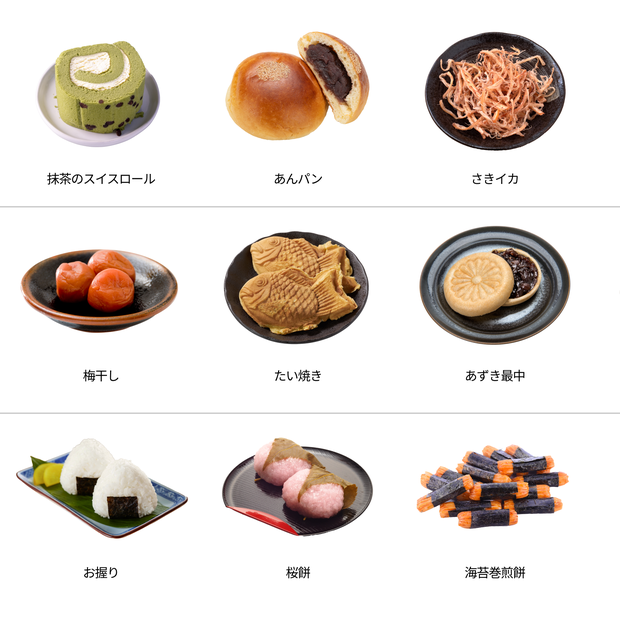

In [9]:
from PIL import Image as PImage


# define the image you want to download
image_url = "https://storage.googleapis.com/generativeai-downloads/images/Japanese_Bento.png" # @param
image_filename = image_url.split("/")[-1]

# download the image
!wget -q $image_url

# visualize the downloaded image
im = PImage.open(image_filename)
im.thumbnail([620,620], PImage.Resampling.LANCZOS)
im

Now you can encode the image and work with the OpenAI library to interact with the Gemini models.

In [10]:
import base64
import requests


# define a helper function to encode the images in base64 format
def encode_image(image_path):
  image = requests.get(image_path)
  return base64.b64encode(image.content).decode('utf-8')

# Getting the base64 encoding
encoded_image = encode_image(image_url)

response = client.chat.completions.create(
  model=MODEL,
  messages=[
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": "Describe the items on this image. If there is any non-English text, translate it as well"
        },
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/png;base64,{encoded_image}",
          },
        },
      ],
    }
  ]
)

Markdown(response.choices[0].message.content)

Here are the items depicted in the image, along with the translation of the non-English text:

Row 1 (Left to Right):
1.  **Item:** A slice of matcha green tea swiss roll cake with cream filling and what appear to be red beans.
    **Text:** 抹茶のスイートロール (Matcha no suītorōru)
    **Translation:** Matcha Swiss roll
2.  **Item:** An anpan, a round bun with red bean paste filling. It is shown whole and cut in half to display the filling.
    **Text:** あんパン (Anpan)
    **Translation:** Anpan (Red bean bread)
3.  **Item:** A pile of dried shredded squid (sakiiika).
    **Text:** さきイカ (Sakiiika)
    **Translation:** Sakiiika (Dried shredded squid)

Row 2 (Left to Right):
4.  **Item:** Several umeboshi, which are pickled plums, in a small bowl.
    **Text:** 梅干し (Umeboshi)
    **Translation:** Umeboshi (Pickled plums)
5.  **Item:** Two taiyaki, a fish-shaped cake typically filled with red bean paste, on a plate.
    **Text:** たい焼き (Taiyaki)
    **Translation:** Taiyaki
6.  **Item:** A monaka, a Japanese dessert consisting of red bean paste filling sandwiched between two thin crisp wafers made from mochi. It is shown whole and cut open.
    **Text:** あずき最中 (Azuki monaka)
    **Translation:** Azuki Monaka (Red bean Monaka)

Row 3 (Left to Right):
7.  **Item:** Two onigiri (rice balls) wrapped in seaweed, served on a leaf with yellow pickled daikon (tsukemono).
    **Text:** お握り (Onigiri)
    **Translation:** Onigiri (Rice ball)
8.  **Item:** Two sakuramochi, a Japanese sweet consisting of pink mochi (rice cake) with red bean paste filling, wrapped in a preserved cherry blossom leaf. Served on a plate with a red spoon-like object.
    **Text:** 桜餅 (Sakuramochi)
    **Translation:** Sakuramochi (Cherry blossom mochi)
9.  **Item:** A pile of norimaki senbei, which are cylindrical rice crackers wrapped in seaweed.
    **Text:** 海苔巻き煎餅 (Norimaki senbei)
    **Translation:** Norimaki Senbei (Seaweed-wrapped rice crackers)

### Working with images (multiple images)

You can do the same process while sending multiple images into the same prompt.

In [11]:
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.pyplot import imread


# define the images you want to download
image_urls = [
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/cesar-couto-OB2F6CsMva8-unsplash.jpg",
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/daniil-silantev-1P6AnKDw6S8-unsplash.jpg",
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/ruslan-bardash-4kTbAMRAHtQ-unsplash.jpg",
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/scopic-ltd-NLlWwR4d3qU-unsplash.jpg",
]

for url in image_urls:
    display(Image(url=url, width=200, height=250))

Now you can encode the images and send them with your prompt.

In [12]:
import base64
import requests


# define a helper function to encode the images in base64 format
def encode_image(image_path):
  image = requests.get(image_path)
  return base64.b64encode(image.content).decode('utf-8')


# Getting the base64 encoding
encoded_images =[]
for image in image_urls:
  encoded_images.append(encode_image(image))

response = client.chat.completions.create(
  model=MODEL,
  messages=[
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": "Describe for what type of living room each of those items are the best match"
        },
        *[{
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_data}",
                    },
        }
                for image_data in encoded_images]
      ],
    }
  ]
)

Markdown(response.choices[0].message.content)

Based on the design and style of each item, here's a description of the type of living room they would best match:

1.  **Wooden Stool with Metal Base:**
    *   **Description:** This stool features a warm wooden seat with a sturdy, dark metal base and an industrial-style adjustable screw mechanism. It has a raw, utilitarian yet characterful look.
    *   **Best Match:** This stool is perfect for **Industrial**, **Rustic-Industrial**, or **Loft-style** living rooms. It fits well in spaces that embrace exposed materials, vintage machinery elements, and a slightly rugged or reclaimed aesthetic. It could serve as an accent piece, occasional seating, or even a unique side table.

2.  **Upholstered Armchair:**
    *   **Description:** This armchair is plush and elegant, with deep button tufting, curved arms and back, and decorative turned legs. It has a soft, luxurious feel.
    *   **Best Match:** This chair is ideally suited for **Traditional**, **Classic**, **Elegant**, **Shabby Chic**, or **Vintage-inspired** living rooms. Its detailed upholstery and sculpted legs add a sense of sophistication, romance, or timeless comfort, making it a beautiful accent piece or part of a formal seating arrangement.

3.  **Simple Wooden Stool:**
    *   **Description:** This is a straightforward, light-colored wooden stool with a square seat and simple, sturdy legs. It has a clean, functional, and somewhat rustic or minimalist design.
    *   **Best Match:** This stool is a great fit for **Rustic**, **Farmhouse**, **Casual Scandinavian**, or **Simple/Minimalist** living rooms. Its unpretentious design and material complement natural elements and functional, uncluttered spaces. It can function as extra seating, a small side table, or even a plant stand.

4.  **Modern Swivel Chair:**
    *   **Description:** This chair has a low profile, a sleek, armless design with a curved, upholstered seat, and a distinctive modern base, possibly designed for swiveling. The base has clean, angular lines, often in wood or metal.
    *   **Best Match:** This chair is best suited for **Modern**, **Contemporary**, or **Minimalist** living rooms. Its clean lines, geometric base, and focus on form and function make it a perfect accent piece for sophisticated, uncluttered spaces. It adds a touch of sculptural design and comfortable, casual lounging.

### Working with audio files

You can also send audio files on your prompt. Audio data provides a more rich input than text alone, and can be use for tasks like transcription, or as direct prompting like a voice assistant.

First you need to download the audio you want to use.

In [13]:
from IPython.display import Audio


audio_url = "https://storage.googleapis.com/generativeai-downloads/data/Apollo-11_Day-01-Highlights-10s.mp3" # @param
audio_filename = audio_url.split("/")[-1]

# download the audio
!wget -q $audio_url

# listen to the downloaded audio
display(Audio(audio_filename, autoplay=False))

Now you will encode the audio in `base64` and send it as part of your request prompt.

In [14]:
# define a helper function to encode the images in base64 format
def encode_audio(audio_path):
  with open(audio_path, 'rb') as audio_file:
    audio_content = audio_file.read()
    return base64.b64encode(audio_content).decode('utf-8')

base64_audio = encode_audio(audio_filename)

prompt = "Transcribe this audio file. After transcribing, tell me from what this can be related to." # @param
response = client.chat.completions.create(
    model=MODEL,
    messages=[
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": prompt,
        },
        {
              "type": "input_audio",
              "input_audio": {
                "data": base64_audio,
                "format": "mp3"
          }
        }
      ],
    }
  ],
)

Markdown(response.choices[0].message.content)

Here is the transcription of the audio:

"Minus 10, 9, 8. We have a go for main engine start. We have main engine start."

This audio can be related to **a rocket launch or a space mission countdown and liftoff sequence.** The phrases "minus ten, nine, eight", "go for main engine start", and "main engine start" are typical calls heard during the final seconds before and immediately after ignition in a rocket launch.

## Structured outputs

Gemini API allows you to format the way your response you be generated via [structured outputs](https://ai.google.dev/gemini-api/docs/structured-output). You can define the structure you want to be used as a defined schema and, using the OpenAI library, you send this structure as the `response_format` parameter.

In this example you will:
- download a scientific paper
- extract its information
- define the structure you want your response in
- send your request using the `response_format` parameter

First you need to download the reference paper. You will use the [Attention is all your need](https://arxiv.org/pdf/1706.03762.pdf) Google paper that introduced the [Transformers architecture](https://en.wikipedia.org/wiki/Transformer_(deep_learning_architecture)).

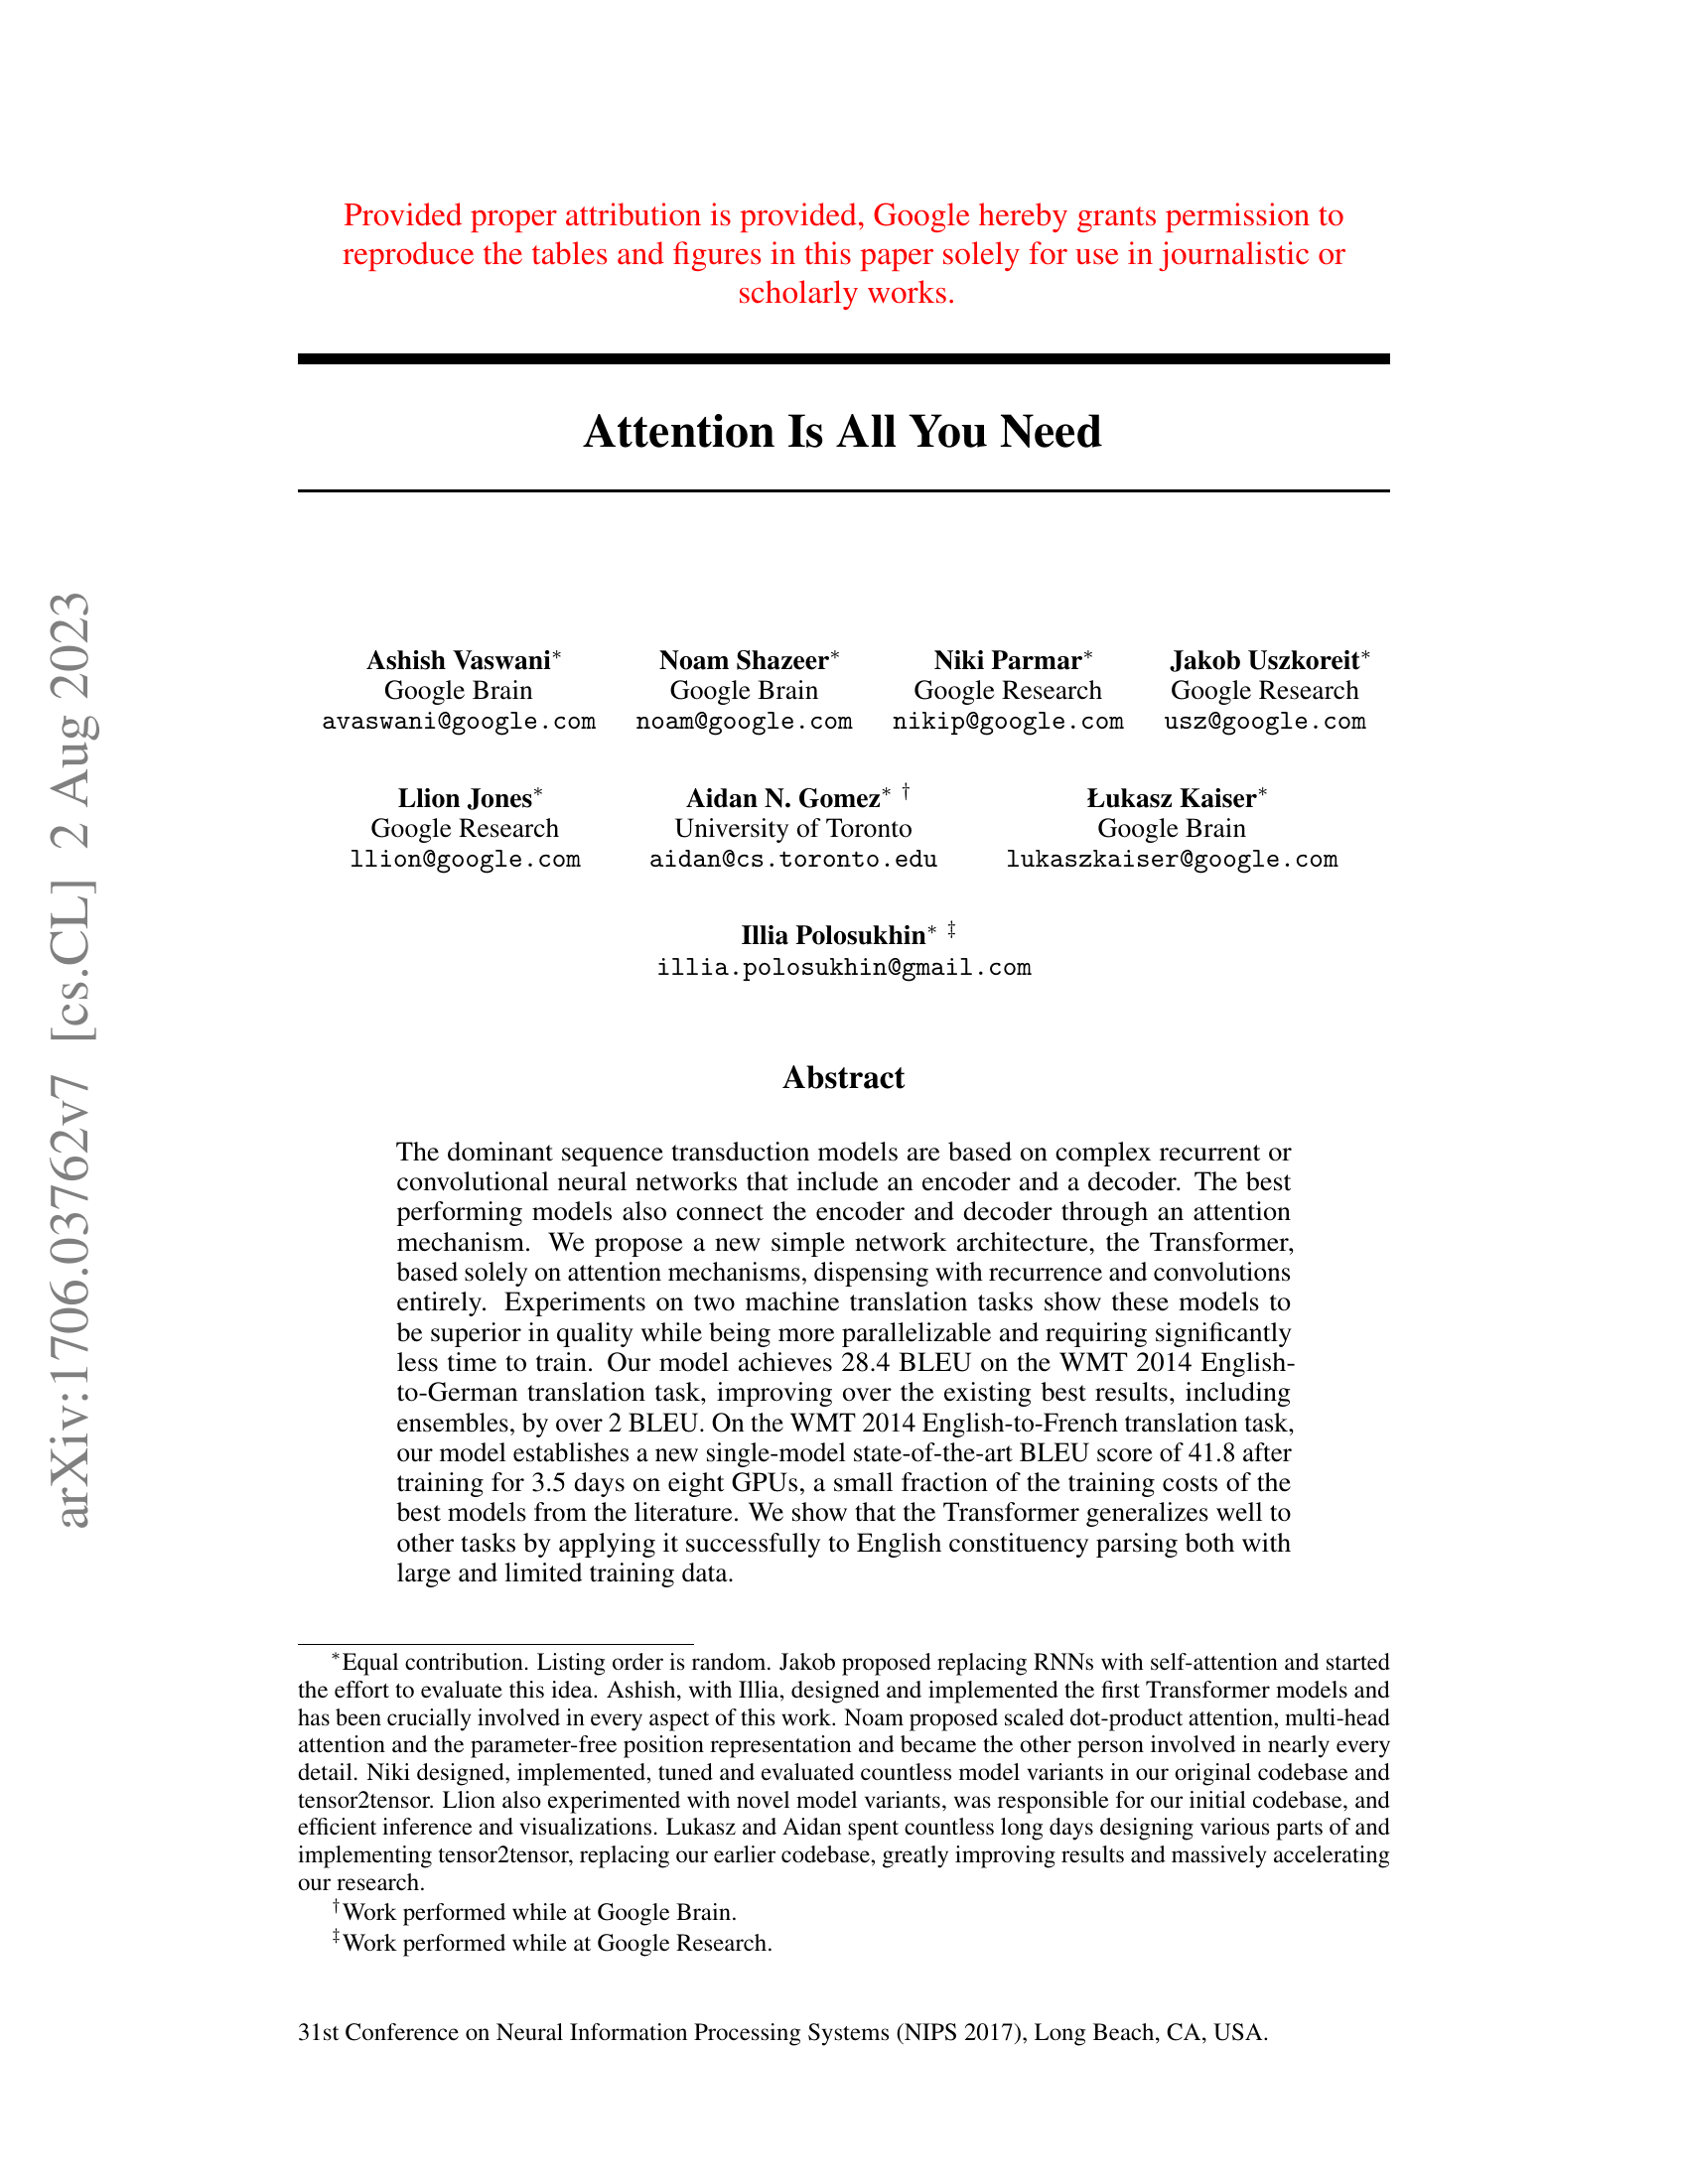

In [15]:
from IPython.display import Image
from pdf2image import convert_from_path


# download the PDF file
pdf_url = "https://arxiv.org/pdf/1706.03762.pdf" # @param
pdf_filename = pdf_url.split("/")[-1]
!wget -q $pdf_url

## visualize the pdf as an image
# convert the PDF file to images
images = convert_from_path(pdf_filename, 200)
for image in images:
  image.save('cover.png', "PNG")
  break

# show the pdf first page
Image('cover.png', width=500, height=600)

Now you will create your reference structure. It will be a Python `Class` that will refer to the title, authors, abstract and keywords from the paper.

In [16]:
from pydantic import BaseModel


class ResearchPaperExtraction(BaseModel):
    title: str
    authors: list[str]
    abstract: str
    keywords: list[str]

Now you will do your request to the Gemini API sending the pdf file and the reference structure.

In [17]:
import json
from pdfminer.high_level import extract_text


# extract text from the PDF
pdf_text = extract_text(pdf_filename)

prompt = """
"As a specialist in knowledge organization and data refinement, your task is to transform
raw research paper content into a clearly defined structured format. I will provide you
with the original, free-form text. Your goal is to parse this text, extract the pertinent
information, and reconstruct it according to the structure outlined below.
"""

# send your request to the Gemini API
completion = client.beta.chat.completions.parse(
  model=MODEL,
  messages=[
    {"role": "system", "content": prompt},
    {"role": "user", "content": pdf_text}
  ],
  response_format=ResearchPaperExtraction,
)

print(completion.choices[0].message.parsed.model_dump_json(indent=2))

{
  "title": "Attention Is All You Need",
  "authors": [
    "Ashish Vaswani",
    "Noam Shazeer",
    "Niki Parmar",
    "Jakob Uszkoreit",
    "Llion Jones",
    "Aidan N. Gomez",
    "Łukasz Kaiser",
    "Illia Polosukhin"
  ],
  "abstract": "The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles, by over 2 BLEU. On the WMT 2014 English-to-Fr

Given the Gemini API ability to handle structured outputs, you can work in more complex scenarios too - like using the structured output functionality to help you generating user interfaces.

First you define the Python classes that represent the structure you want in the output.

In [18]:
from enum import Enum


class UIType(str, Enum):
    div = "div"
    button = "button"
    header = "header"
    section = "section"
    field = "field"
    form = "form"

class Attribute(BaseModel):
    name: str
    value: str

class UI(BaseModel):
    type: UIType
    label: str
    children: list[str]
    attributes: list[Attribute]

UI.model_rebuild() # This is required to enable recursive types

class Response(BaseModel):
    ui: UI

Now you send your request using the `Response` class as the `response_format`.

In [19]:
completion = client.beta.chat.completions.parse(
    model=MODEL,
    messages=[
        {"role": "system", "content": "You are a UI generation assistant. Convert the user input into a UI."},
        {"role": "user", "content": "Make a User Profile Form including all required attributes"}
    ],
    response_format=Response,
)

print(completion.choices[0].message.content)

{
  "ui": {
    "children": [
      "name",
      "email",
      "address"
    ],
    "attributes": [
      {
        "value": "user-form",
        "name": "class"
      },
      {
        "value": "/submit-profile",
        "name": "action"
      },
      {
        "value": "post",
        "name": "method"
      }
    ],
    "type": "form",
    "label": "User Profile"
  }
}


## Developing with the Gemini API Function Calling

The Gemini API's function calling feature allows you to extend the model's capabilities by providing descriptions of external functions or APIs.

For further understanding of how function calling works with Gemini models, check the [Gemini API documentation](https://ai.google.dev/gemini-api/docs/function-calling).

In [20]:
tools = [
  {
    "type": "function",
    "function": {
      "name": "get_weather",
      "description": "Gets the weather at the user's location",
      "parameters": {
        "type": "object",
        "properties": {
          "location": {"type": "string"},
        },
      },
    },
  }
]

Now you add the `tools` structure on your request.

In [21]:
prompt = """
What's the weather like in Boston?
"""

completion = client.chat.completions.create(
  model=MODEL,
  messages=[{"role": "user", "content": prompt}],
  tools=tools,
)

print(completion.choices[0].message.tool_calls[0])

ChatCompletionMessageToolCall(id='', function=Function(arguments='{"location":"Boston"}', name='get_weather'), type='function')


## Using the `Gemini 2.5` models thinking capabilities

The [Gemini 2.5](https://ai.google.dev/gemini-api/docs/thinking) are an preview models that's trained to generate the "thinking process" the model goes through as part of its response. As a result, the Flash Thinking model is capable of stronger reasoning capabilities in its responses than the Gemini 2.0 models.

You can also use the Gemini API to use this model on your experiments in a very simple way.

In [22]:
MODEL="gemini-2.5-flash-preview-04-17"
prompt = """
What is 45-78+5x13?
Double check and explain why your answer is correct.
"""

response = client.chat.completions.create(
  model=MODEL,
  messages=
   [
      {
        "role": "user",
        "content": prompt
      }
  ]
)

Markdown(response.choices[0].message.content)

To solve the expression 45 - 78 + 5 x 13, we need to follow the order of operations (PEMDAS/BODMAS).

The order is:
1.  **P**arentheses / **B**rackets
2.  **E**xponents / **O**rders
3.  **M**ultiplication and **D**ivision (from left to right)
4.  **A**ddition and **S**ubtraction (from left to right)

Let's apply this to the expression: 45 - 78 + 5 x 13

1.  There are no parentheses or exponents.
2.  We have multiplication: 5 x 13.
    *   5 x 13 = 65
    The expression becomes: 45 - 78 + 65
3.  Now we have addition and subtraction. We perform these from left to right.
    *   First, the subtraction: 45 - 78.
        *   45 - 78 = -33
    The expression becomes: -33 + 65
    *   Next, the addition: -33 + 65.
        *   -33 + 65 = 32

So, the answer is 32.

**Double Check and Explanation:**

1.  **Identify Operations:** The operations are subtraction (-), addition (+), and multiplication (*).
2.  **Apply Order of Operations (PEMDAS/BODMAS):**
    *   Multiplication comes before addition and subtraction. We *must* calculate 5 x 13 first.
    *   5 x 13 = 65.
3.  **Substitute and Simplify:** The expression is now 45 - 78 + 65.
4.  **Perform Addition and Subtraction from Left to Right:**
    *   Start from the left: 45 - 78.
    *   45 - 78 = -33. (You are subtracting a larger number from a smaller one, resulting in a negative number).
5.  **Substitute and Simplify Again:** The expression is now -33 + 65.
6.  **Perform the final Addition:**
    *   -33 + 65 = 32. (Adding a positive number to a negative number is the same as subtracting the absolute value of the negative number from the positive number: 65 - 33 = 32).

The steps followed the correct mathematical order of operations, ensuring the calculation is performed in the proper sequence (multiplication first, then subtraction/addition from left to right). Each step was calculated correctly.

The final answer is **32**.

## Generating and working with embeddings

Text embeddings offer a compressed, vector-based representation of text, typically in a lower-dimensional space. The core principle is that semantically similar texts will have embeddings that are spatially proximate within the embedding vector space. This representation enables solutions to several prevalent NLP challenges, including:

- **Semantic Search:** Identifying and ranking texts based on semantic relatedness.
- **Recommendation:** Suggesting items whose textual descriptions exhibit semantic similarity to a given input text.
- **Classification:** Assigning text to categories based on the semantic similarity between the text and the category's representative text.
- **Clustering:** Grouping texts into clusters based on the semantic similarity reflected in their respective embedding vectors.
- **Outlier Detection:** Identifying texts that are semantically dissimilar from the majority, as indicated by their distance in the embedding vector space.

For more details about working with the Gemini API and embeddings, check the [API documentation](https://ai.google.dev/gemini-api/docs/embeddings).

In this example you will use the `gemini-embedding-exp-03-07` model from the Gemini API to generate your embeddings.

In [23]:
EMBEDDINGS_MODEL="gemini-embedding-exp-03-07"
prompt = """
The quick brown fox jumps over the lazy dog.
"""

response = client.embeddings.create(
  model=EMBEDDINGS_MODEL,
  input=prompt,
)

print(len(response.data[0].embedding))
print(response.data[0].embedding[:4], '...')

3072
[-0.0108722522854805, 0.019908268004655838, -0.003474034368991852, -0.045275624841451645] ...


A simple application of text embeddings is to calculate the similarity between sentences (ie. product reviews, documents contents, etc). First you will create a group of sentences.

In [24]:
import pandas as pd


text = [
    "i really enjoyed the movie last night",
    "so many amazing cinematic scenes yesterday",
    "had a great time writing my Python scripts a few days ago",
    "huge sense of relief when my .py script finally ran without error",
    "O Romeo, Romeo, wherefore art thou Romeo?",
]

df = pd.DataFrame(text, columns=["text"])
df

,text
0,i really enjoyed the movie last night
1,so many amazing cinematic scenes yesterday
2,had a great time writing my Python scripts a f...
3,huge sense of relief when my .py script finall...
4,"O Romeo, Romeo, wherefore art thou Romeo?"


Now you can create a function to generate embeddings, apply that function to your dataframe `text` column and save it into a new column called `embeddings`.

In [25]:
def generate_embeddings(text):
  response = client.embeddings.create(
    model=EMBEDDINGS_MODEL,
    input=text,
  )
  return response.data[0].embedding

df["embeddings"] = df.apply(
    lambda x: generate_embeddings([x.text]), axis=1
)
df

,text,embeddings
0,i really enjoyed the movie last night,"[-0.015758849680423737, -0.00223345635458827, ..."
1,so many amazing cinematic scenes yesterday,"[-0.01200825534760952, 0.007556390017271042, 0..."
2,had a great time writing my Python scripts a f...,"[0.0065507469698786736, 0.0018844676669687033,..."
3,huge sense of relief when my .py script finall...,"[-0.008062172681093216, -0.006349125877022743,..."
4,"O Romeo, Romeo, wherefore art thou Romeo?","[-0.02323131076991558, 0.0021875633392482996, ..."


Now that you have the embeddings representations for all sentences, you can calculate their similarities.

In [26]:
from sklearn.metrics.pairwise import cosine_similarity


cos_sim_array = cosine_similarity(list(df.embeddings.values))

# display as DataFrame
analysis = pd.DataFrame(cos_sim_array, index=text, columns=text)
analysis

,i really enjoyed the movie last night,so many amazing cinematic scenes yesterday,had a great time writing my Python scripts a few days ago,huge sense of relief when my .py script finally ran without error,"O Romeo, Romeo, wherefore art thou Romeo?"
i really enjoyed the movie last night,1.000000,0.653648,0.645156,0.602606,0.508644
so many amazing cinematic scenes yesterday,0.653648,1.000000,0.649567,0.611159,0.528216
had a great time writing my Python scripts a few days ago,0.645156,0.649567,1.000000,0.810877,0.476175
huge sense of relief when my .py script finally ran without error,0.602606,0.611159,0.810877,1.000000,0.462184
"O Romeo, Romeo, wherefore art thou Romeo?",0.508644,0.528216,0.476175,0.462184,1.000000


You can also plot it for a better visualization.

[Text(0.5, 1, 'i really enjoyed the movie last night'),
 Text(1.5, 1, 'so many amazing cinematic scenes yesterday'),
 Text(2.5, 1, 'had a great time writing my Python scripts a few days ago'),
 Text(3.5, 1, 'huge sense of relief when my .py script finally ran without error'),
 Text(4.5, 1, 'O Romeo, Romeo, wherefore art thou Romeo?')]

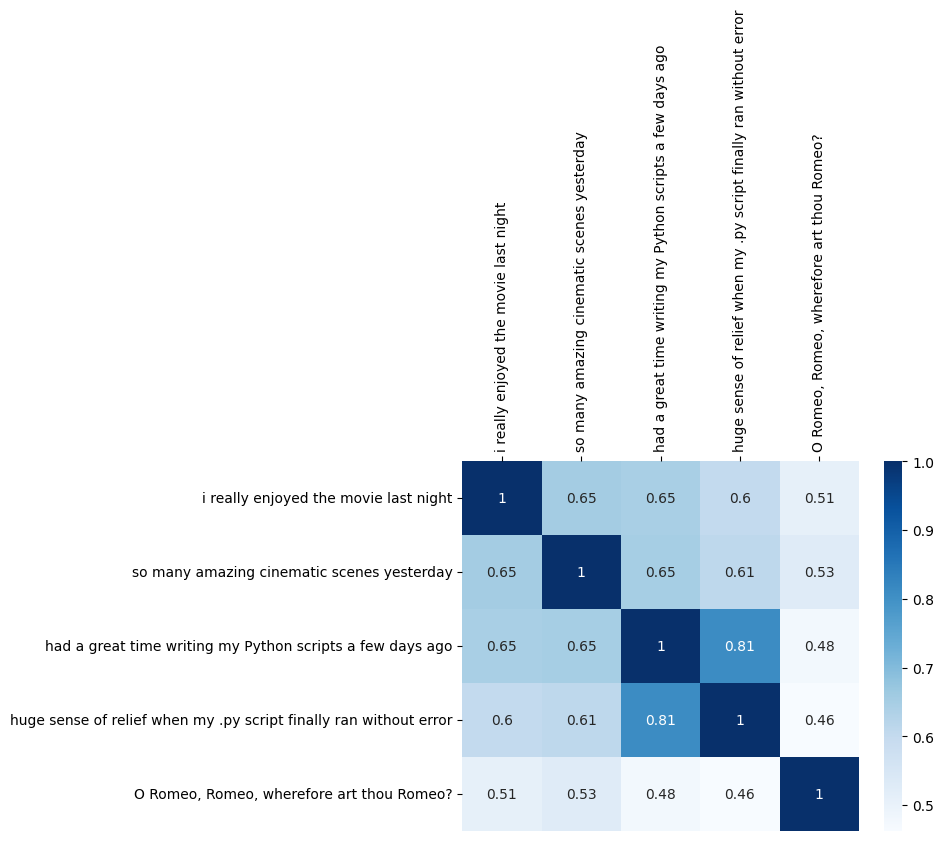

In [28]:
import seaborn as sns


ax = sns.heatmap(analysis, annot=True, cmap="Blues")
ax.xaxis.tick_top()
ax.set_xticklabels(text, rotation=90)

## Next Steps

### Useful API references:

Check out the [Google GenAI SDK](https://github.com/googleapis/python-genai) for more details on the SDK.

### Related examples

For more detailed examples using Gemini 2.0, check the [Gemini 2.0 folder of the cookbook](https://github.com/google-gemini/cookbook/tree/main/gemini-2/) with guides usin the [Google GenAI SDK](https://github.com/googleapis/python-genai). You'll learn how to use the [Live API](./Get_started_LiveAPI.ipynb), juggle with [multiple tools](../examples/LiveAPI_plotting_and_mapping.ipynb) or use Gemini 2.0 [spatial understanding](./Spatial_understanding.ipynb) abilities.

Also check the [experimental Gemini 2.0 Flash Thinking](./Get_started_thinking.ipynb) model that explicitly showcases its thoughts and can manage more complex reasonings.